In [1]:
# Verbindung zur MongoDB-Datenbank 
from pymongo import MongoClient
from bson.objectid import ObjectId
from bson import json_util
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def connect_to_mongo(db_name, collection_name, uri="mongodb://mongo:27017/"):
    # Verbindung zu MongoDB herstellen
    client = MongoClient(uri, unicode_decode_error_handler='ignore')
    db = client[db_name]
    collection = db[collection_name]
    return collection

def getCollection():
    db_name = "car_crashes"
    collection_name = "crashes"
    
    # Verbindung zur Collection herstellen
    return connect_to_mongo(db_name, collection_name)

def getPandasDataFrame(where, select):
    collection = getCollection()
    
    # Daten abfragen
    crashes = collection.find(where, select)
    
    documents = []
    for document in crashes:
        try:
            # BSON-Dokument in JSON umwandeln und zur Liste hinzufügen
            documents.append(document)
        except Exception as e:
            print(f"Fehler beim Verarbeiten eines Dokuments: {e}")

    return pd.DataFrame(documents)
    

def printDocs (docs, pretty=True): 
    for d in docs: print (json_util.dumps(d, indent=2) if pretty else d)


In [ ]:
collection = getCollection()

In [ ]:
def analyze_frequency():
    df = getPandasDataFrame({}, {"crashDate": 1, "crashTime": 1, "onStreetName": 1, "offStreetName": 1, "location": 1})
    
    # crashDate in datetime umwandeln
    df['crashDate'] = pd.to_datetime(df['crashDate'], format='%d.%m.%Y')
    
    # Daten visualisieren
    visualize_data(df)

# Function to visualize data
def visualize_data(df):
    # Crash-Frequenz nach Datum
    plt.figure(figsize=(12, 6))
    df['crashDate'].value_counts().sort_index().plot(kind='line')
    plt.title('Crash Frequency Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Crashes')
    plt.grid(True)
    plt.show()
    
    # Crash-Frequenz nach Wochentag
    plt.figure(figsize=(12, 6))
    df['weekday'] = df['crashDate'].dt.day_name()
    sns.countplot(x='weekday', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.title('Crash Frequency by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Crashes')
    plt.xticks(rotation=45)
    plt.show()

    # Crash-Frequenz nach Stunde
    plt.figure(figsize=(12, 6))
    df['hour'] = pd.to_datetime(df['crashTime'], format='%H:%M').dt.hour
    sns.countplot(x='hour', data=df)
    plt.title('Crash Frequency by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Crashes')
    plt.xticks(rotation=45)
    plt.show()

analyze_frequency()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_causes():
    df = getPandasDataFrame({
                                'contributingFactorVehicle1': {'$exists': True, '$ne': ''}, 
                                'contributingFactorVehicle2': {'$exists': True, '$ne': ''},
                                'vehicleTypeCode1': {'$exists': True, '$ne': ''}, 
                                'vehicleTypeCode2': {'$exists': True, '$ne': ''} 
                              }, {
        "contributingFactorVehicle1": 1,
        "contributingFactorVehicle2": 1,
        "vehicleTypeCode1": 1,
        "vehicleTypeCode2": 1,
        "persons": 1
    })
    
    # DataFrame erweitern um Informationen aus dem 'persons' Array
    persons_data = []
    for idx, row in df.iterrows():
        if "persons" in row:
            for person in row["persons"]:
                # Überprüfen, ob die relevanten Felder vorhanden sind und nicht leer sind
                if person["emotionalStatus"] != "" and person["bodilyInjury"] != "":
                    person_data = {
                        "emotionalStatus": person.get("emotionalStatus"),
                        "bodilyInjury": person.get("bodilyInjury")
                    }
                    # Merge mit den ursprünglichen Feldern
                    merged_data = {**row.to_dict(), **person_data}
                    persons_data.append(merged_data)
    
    # Neues DataFrame mit erweiterten Informationen
    df_expanded = pd.DataFrame(persons_data)
    
    # Daten für die Top 10 Werte filtern
    top_n = 10
    
    # Häufigkeit der beitragenden Faktoren für Fahrzeug 1
    contributing_factors_vehicle1_top10 = df_expanded['contributingFactorVehicle1'].value_counts().nlargest(top_n)
    
    # Häufigkeit der Fahrzeugtypen
    vehicle_types_top10 = df_expanded['vehicleTypeCode1'].value_counts().nlargest(top_n)
    
    # Emotionale Zustände der Fahrer
    emotional_status_top10 = df_expanded['emotionalStatus'].value_counts().nlargest(top_n)
    
    # Körperverletzungen der Fahrer
    bodily_injuries_top10 = df_expanded['bodilyInjury'].value_counts().nlargest(top_n)
    
    # Daten visualisieren
    visualize_data(contributing_factors_vehicle1_top10, vehicle_types_top10, emotional_status_top10, bodily_injuries_top10)

# Funktion zur Datenvisualisierung
def visualize_data(contributing_factors_vehicle1, vehicle_types, emotional_status, bodily_injuries):
    # Plot für beitragende Faktoren für Fahrzeug 1
    plt.figure(figsize=(12, 6))
    sns.barplot(x=contributing_factors_vehicle1.values, y=contributing_factors_vehicle1.index, orient='h')
    plt.title('Top 10 Contributing Factors for Vehicle 1')
    plt.xlabel('Count')
    plt.ylabel('Contributing Factor')
    plt.show()

    # Plot für Fahrzeugtypen
    plt.figure(figsize=(12, 6))
    sns.barplot(x=vehicle_types.values, y=vehicle_types.index, orient='h')
    plt.title('Top 10 Vehicle Types Involved in Crashes')
    plt.xlabel('Count')
    plt.ylabel('Vehicle Type')
    plt.show()

    # Plot für emotionale Zustände der Fahrer
    plt.figure(figsize=(12, 6))
    sns.barplot(x=emotional_status.values, y=emotional_status.index, orient='h')
    plt.title('Top 10 Emotional Status of Drivers Involved in Crashes')
    plt.xlabel('Count')
    plt.ylabel('Emotional Status')
    plt.show()

    # Plot für Körperverletzungen der Fahrer
    plt.figure(figsize=(12, 6))
    sns.barplot(x=bodily_injuries.values, y=bodily_injuries.index, orient='h')
    plt.title('Top 10 Bodily Injuries of Drivers Involved in Crashes')
    plt.xlabel('Count')
    plt.ylabel('Bodily Injury')
    plt.show()

analyze_causes()


In [ ]:
def analyze_dangerous_sections():
    df = getPandasDataFrame({'onStreetName': {'$exists': True, '$ne': ''}}, {
        "onStreetName": 1,
        "offStreetName": 1,
        "numberOfPersonsInjured": 1,
        "numberOfPersonsKilled": 1
    })
    
    # Bereinigung und Konvertierung der numerischen Werte
    df['numberOfPersonsInjured'] = pd.to_numeric(df['numberOfPersonsInjured'], errors='coerce').fillna(0).astype(int)
    df['numberOfPersonsKilled'] = pd.to_numeric(df['numberOfPersonsKilled'], errors='coerce').fillna(0).astype(int)
    
    # Gruppieren nach 'onStreetName' und 'offStreetName' und die Anzahl der Verletzten und Toten summieren
    df_grouped = df.groupby(['onStreetName', 'offStreetName']).agg({
        'numberOfPersonsInjured': 'sum',
        'numberOfPersonsKilled': 'sum'
    }).reset_index()

    # Daten visualisieren
    visualize_data(df_grouped)

def visualize_data(df):
    import matplotlib.pyplot as plt

    # Sortieren nach der Anzahl der Verletzten und Toten
    df_sorted = df.sort_values(by=['numberOfPersonsInjured', 'numberOfPersonsKilled'], ascending=False).head(10)

    # Barplot erstellen
    ax = df_sorted.plot(kind='bar', x='onStreetName', y=['numberOfPersonsInjured', 'numberOfPersonsKilled'], stacked=True)
    plt.title('Top 10 gefährliche Straßenabschnitte')
    plt.xlabel('Straßenabschnitt (onStreetName)')
    plt.ylabel('Anzahl der Personen')
    plt.xticks(rotation=45, ha='right')
    plt.legend(["Anzahl Verletzter", "Anzahl Getöteter"])
    plt.tight_layout()
    
    plt.show()
    
    ax = df_sorted.plot(kind='bar', x='onStreetName', y=['numberOfPersonsKilled'], stacked=True)
    plt.title('Top 10 gefährliche Straßenabschnitte')
    plt.xlabel('Straßenabschnitt (onStreetName)')
    plt.ylabel('Anzahl der Personen')
    plt.xticks(rotation=45, ha='right')
    plt.legend(["Anzahl Getöteter"])
    plt.tight_layout()
    
    plt.show()

analyze_dangerous_sections()

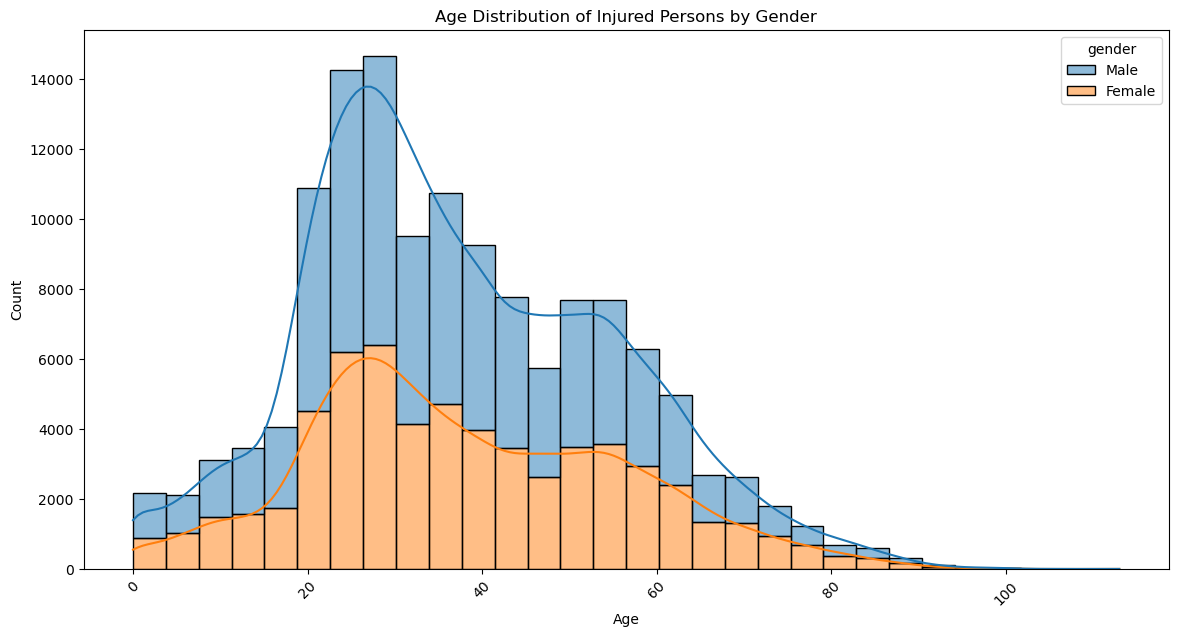

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_injuries_victim_profiles():
    df = getPandasDataFrame({}, {
        "persons": 1
    })
    
    # DataFrame erweitern um Informationen aus dem 'persons' Array
    persons_data = []
    for idx, row in df.iterrows():
        if "persons" in row:
            for person in row["persons"]:
                if person['age'] != '' and person['type'] != '' and person['gender'] != '' and person['bodilyInjury'] != '':
                    person_data = {
                        "age": person.get("age"),
                        "type": person.get("type"),
                        "gender": person.get("gender"),
                        "bodilyInjury": person.get("bodilyInjury")
                    }
                    # Merge mit den ursprünglichen Feldern
                    merged_data = {**row.to_dict(), **person_data}
                    persons_data.append(merged_data)
    
    # Neues DataFrame mit erweiterten Informationen
    df_expanded = pd.DataFrame(persons_data)
    
    # Analyse der Opferprofile
    analyze_victim_profiles(df_expanded)


def analyze_victim_profiles(df):
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    
    # Sort DataFrame by 'age' column
    df = df.sort_values(by='age')
    
#     # Verteilung der Altersgruppen der beteiligten Personen
#     plt.figure(figsize=(14, 7))  # Larger figure size
#     sns.histplot(data=df, x='age', bins=30, kde=True)
#     plt.title('Age Distribution of Persons Involved in Accidents')
#     plt.xlabel('Age')
#     plt.ylabel('Count')
#     plt.xticks(rotation=45)  # Rotates x-axis labels for better readability if needed
#     plt.show()
    
    # Verteilung der Geschlechter der beteiligten Personen
#     plt.figure(figsize=(8, 5))
#     sns.countplot(x='gender', data=df)
#     plt.title('Gender Distribution of Persons Involved in Accidents')
#     plt.xlabel('Gender')
#     plt.ylabel('Count')
#     plt.show()
    
#     # Verteilung der Personentypen (Fahrer, Beifahrer usw.)
#     plt.figure(figsize=(10, 6))
#     sns.countplot(y='type', data=df, order=df['type'].value_counts().index)
#     plt.title('Distribution of Person Types Involved in Accidents')
#     plt.xlabel('Count')
#     plt.ylabel('Person Type')
#     plt.show()
    
    # Verteilung der Verletzungen nach Altersgruppen und Geschlecht
    plt.figure(figsize=(14, 7))
    sns.histplot(data=df, x='age', hue='gender', multiple='stack', bins=30, kde=True)
    plt.title('Age Distribution of Injured Persons by Gender')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotates x-axis labels for better readability if needed
    plt.show()

analyze_injuries_victim_profiles()
